# Preprocessing of parsed data

# Part 1. Air traffic and airports data

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

In [3]:
airport_df = pd.read_csv("../data/airport_df.csv", index_col=0)
airport_df.head()

,Name,City,Country,IATA,ICAO,Lat,Long,Alt,Timezone,DST,Tz database time zone,type,source
ID,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [4]:
airport_df.drop(
    ['ICAO', 'Alt', 'Timezone', 'DST', 'Tz database time zone', 'type', 'source'],
    axis=1, 
    inplace=True
)
airport_df = airport_df[~airport_df.IATA.isin([r"\N"])]
airport_df.shape

(6072, 6)

In [7]:
connections_df = pd.read_csv("../data/connections_df.csv", index_col=0)
print(connections_df.shape)
connections_df.head()

(67663, 9)


,Airline,Airline ID,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Codeshare,Stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [8]:
routes = pd.read_csv("../data/routes.csv", index_col=0)
print(routes.shape)
routes.head()

(28330, 3)


,course_code,destination_code,destination_flights
0,AAA,PPT,6
1,AAA,MKP,0
2,AAA,RRR,0
3,AAA,FAC,0
4,AAK,TRW,12


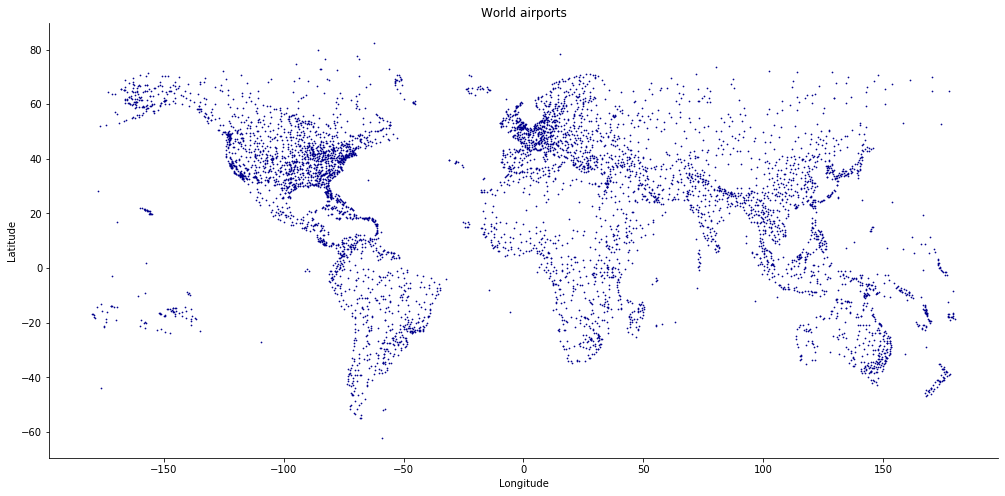

In [18]:
plt.figure(figsize=(17, 8))
plt.title("World airports")
plt.scatter(airport_df.Long, airport_df.Lat, s=0.5, c='darkblue')
plt.ylabel("Latitude")
plt.xlabel("Longitude")
sns.despine()
plt.show()

## Merging the dataframes

In [19]:
connections = pd.merge(
    connections_df, 
    routes, 
    how='left', 
    left_on=['Source Airport', 'Dest Airport'], 
    right_on=['course_code', 'destination_code']
)

connections.drop(
    ['course_code', 'destination_code', 'Codeshare', 'Stops', 'equipment'],
    axis=1, inplace=True
)

connections.columns = connections.columns.str.lower().str.split().str.join("_")
connections.head()

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,destination_flights
0,2B,410,AER,2965,KZN,2990,16.0
1,2B,410,ASF,2966,KZN,2990,12.0
2,2B,410,ASF,2966,MRV,2962,8.0
3,2B,410,CEK,2968,KZN,2990,NaN
4,2B,410,CEK,2968,OVB,4078,30.0


## Problem - half of connections don't have the estimated number of flights

In [22]:
connections.isnull().sum()/connections.shape[0]

airline                0.000000
airline_id             0.000000
source_airport         0.000000
source_airport_id      0.000000
dest_airport           0.000000
dest_airport_id        0.000000
destination_flights    0.506909
dtype: float64

## Idea - fill missing number of flights with minimal number of flights from that source

In [23]:
MINIMAL_FLIGHTS_ESTIMATE = 0.1

minimal_flights = connections[
    (connections.destination_flights!=0)&(~connections.destination_flights.isnull())
].groupby(['source_airport']).destination_flights.min()

minimal_flights = np.ceil(minimal_flights*MINIMAL_FLIGHTS_ESTIMATE)

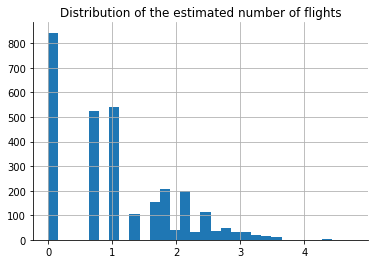

In [31]:
minimal_flights.apply(np.log).hist(bins=30)
sns.despine()
plt.title("Distribution of the estimated number of flights")
plt.show()

In [28]:
# filling the missing values with the estimates
connections.destination_flights[
    (connections.destination_flights.isnull())|(connections.destination_flights==0)
] = connections[
    (connections.destination_flights.isnull())|(connections.destination_flights==0)
]['source_airport'].map(minimal_flights)

## Sanity check

The distributions of the number of flights before and after filling the missing data should be approximately the same (properties preservation)

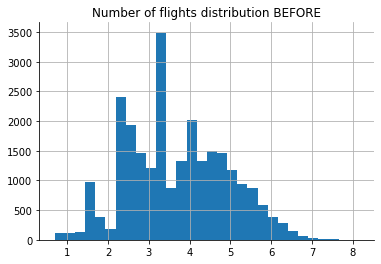

In [32]:
(routes.destination_flights[routes.destination_flights!=0]+1).apply(np.log).hist(bins=30)
plt.title("Number of flights distribution BEFORE")
sns.despine()
plt.show()

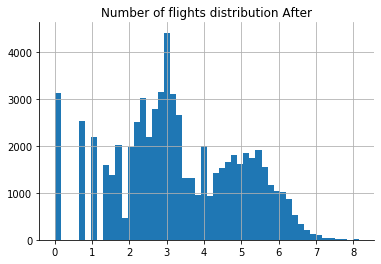

In [33]:
(connections.destination_flights).apply(np.log).hist(bins=50)
plt.title("Number of flights distribution After")
sns.despine()
plt.show()

--- 

## Adding airports locations to the dataframe

In [34]:
connections = pd.merge(
    connections, airport_df[['IATA', 'Lat', 'Long']], left_on='source_airport', right_on='IATA')

connections = pd.merge(
    connections, airport_df[['IATA', 'Lat', 'Long']], left_on='dest_airport', right_on='IATA')

connections.drop(['IATA_x', 'IATA_y'], axis=1, inplace=True)

connections.rename(columns={
    'Lat_x':'lat_source', 
    'Long_x':'long_source',
    'Lat_y':'lat_dest',
    'Long_y':'long_dest'
}, inplace=True)

# A few flights estimations were still missing - filling with median
connections.fillna(connections.destination_flights.median(), inplace=True)

In [35]:
connections.head()

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,destination_flights,lat_source,long_source,lat_dest,long_dest
0,2B,410,AER,2965,KZN,2990,16.0,43.449902,39.956600,55.606201,49.278702
1,2B,410,ASF,2966,KZN,2990,12.0,46.283298,48.006302,55.606201,49.278702
2,2B,410,CEK,2968,KZN,2990,1.0,55.305801,61.503300,55.606201,49.278702
3,2B,410,DME,4029,KZN,2990,141.0,55.408798,37.906300,55.606201,49.278702
4,S7,4329,DME,4029,KZN,2990,141.0,55.408798,37.906300,55.606201,49.278702


# Part 2. Population data

In [36]:
population_country = pd.read_csv("../data/country_population.csv", index_col=0)
population_country.pop2019 = population_country.pop2019 * 1000
print(population_country.shape)
population_country.head()

(232, 6)


,name,pop2019,pop2018,GrowthRate,area,Density
Rank,,,,,,
1,China,1.433784e+09,NaN,1.0039,9706961.0,147.7068
2,India,1.366418e+09,NaN,1.0099,3287590.0,415.6290
3,United States,3.290649e+08,NaN,1.0059,9372610.0,35.1092
4,Indonesia,2.706256e+08,NaN,1.0107,1904569.0,142.0928
5,Pakistan,2.165653e+08,NaN,1.0200,881912.0,245.5634


In [37]:
population_city = pd.read_csv("../data/city_population.csv", index_col=0)
print(population_city.shape)
population_city.head()

(1723, 5)


,Rank,Name,2020 Population,2019 Population,Change
0,1,Tokyo,37393129,37435191,-0.11%
1,2,Delhi,30290936,29399141,3.03%
2,3,Shanghai,27058479,26317104,2.82%
3,4,Sao Paulo,22043028,21846507,0.90%
4,5,Mexico City,21782378,21671908,0.51%


## Adding city and country population to airports dataframe

In [38]:
airport_df = pd.merge(
    airport_df, 
    population_city.rename(
        columns={"Name":"City", "2020 Population":"city_population"}
    )[['City', 'city_population']], 
    how='left', 
    left_on='City', 
    right_on='City'
)

airport_df = pd.merge(
    airport_df, 
    population_country.rename(
        columns={"name":"Country", "pop2019":"country_population", 'Density':'country_density'}
    )[['Country', 'country_population', 'country_density']], 
    how='left', 
    left_on='Country', 
    right_on='Country'
)

In [39]:
airport_df.head()

,Name,City,Country,IATA,Lat,Long,city_population,country_population,country_density
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998,NaN,8776109.0,18.9614
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001,NaN,8776109.0,18.9614
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005,NaN,8776109.0,18.9614
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977,NaN,8776109.0,18.9614
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001,382516.0,8776109.0,18.9614


In [41]:
airport_df.isnull().sum()/airport_df.shape[0]

Name                  0.000000
City                  0.006416
Country               0.000000
IATA                  0.000000
Lat                   0.000000
Long                  0.000000
city_population       0.810495
country_population    0.018260
country_density       0.018260
dtype: float64

## Problem - 81% of city population is missing!

One solution could be parsing wikipedia but we can also try and estimate the population size based on the flights info!

## Hypothesis - the number of flights from the city is proportional to the city population

In [42]:
# Removing 1.8% of observations with missing country info
airport_df = airport_df[~airport_df.country_population.isnull()]

In [43]:
flights_number = connections.groupby(
    ['source_airport'], as_index=False
)[['destination_flights']].sum()
flights_number.head()

,source_airport,destination_flights
0,AAE,198.0
1,AAL,1092.0
2,AAN,16.0
3,AAQ,187.0
4,AAR,224.0


In [44]:
# adding source airport number of flights to the airport dataframe
airport_df = pd.merge(
    airport_df, flights_number, 
    how='left', 
    left_on='IATA', 
    right_on='source_airport'
)

In [60]:
airport_df = airport_df[~airport_df.source_airport.isnull()]
airport_df = airport_df[~airport_df.destination_flights.isnull()]

In [48]:
# calculating the number of flights on a country level to fill missing flight values
country_level_flights = np.ceil(
    airport_df[
        airport_df.destination_flights!=0
    ].groupby("Country")['destination_flights'].min() * MINIMAL_FLIGHTS_ESTIMATE
)

airport_df.destination_flights[
    airport_df.destination_flights==0
] = airport_df[
    airport_df.destination_flights==0
]['Country'].map(country_level_flights)

## Let's see if our hypothesis holds

In [50]:
airport_df[['destination_flights', 'city_population', 'country_population', 'country_density']].corr()

,destination_flights,city_population,country_population,country_density
destination_flights,1.000000,0.511136,0.161578,0.114862
city_population,0.511136,1.000000,0.131050,0.110071
country_population,0.161578,0.131050,1.000000,0.047729
country_density,0.114862,0.110071,0.047729,1.000000


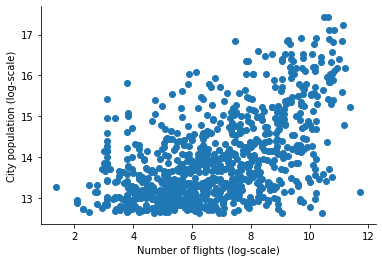

In [57]:
plt.scatter(
    np.log(airport_df.destination_flights), 
    np.log(airport_df.city_population)
)
plt.ylabel("City population (log-scale)")
plt.xlabel("Number of flights (log-scale)")
sns.despine()
plt.show()

## Now we can calculate the "average population per flight"...

In [58]:
flights_coefs = airport_df[
    ~airport_df.city_population.isnull()
].groupby("Country")[['city_population', 'destination_flights']].sum()
flights_coefs['coef'] = flights_coefs['city_population']/flights_coefs['destination_flights']

In [59]:
flights_coefs

,city_population,destination_flights,coef
Country,,,
Afghanistan,1103577.0,470.0,2348.036170
Albania,493712.0,668.0,739.089820
Algeria,1900157.0,1197.0,1587.432749
Angola,11272306.0,1159.0,9725.889560
Argentina,39722069.0,19222.0,2066.489907
...,...,...,...
Venezuela,16611883.0,1235.0,13450.917409
Vietnam,3647383.0,28339.0,128.705424
Yemen,4798597.0,1474.0,3255.493216


In [61]:
airport_df['flights_coefficient'] = airport_df.Country.map(flights_coefs.coef)
airport_df['flights_coefficient'].fillna(airport_df['flights_coefficient'].median(), inplace=True)

## ... and use this coefficient to fill the missing population data

In [62]:
city_estimates = np.ceil(airport_df.flights_coefficient[airport_df.city_population.isnull()] *\
                 airport_df.destination_flights[airport_df.city_population.isnull()])

airport_df.city_population[airport_df.city_population.isnull()] = city_estimates

## Finally - clean connections data and get daily flights estimates from monthly data

In [63]:
connections = connections[connections.source_airport.isin(airport_df.IATA)]
connections = connections[connections.dest_airport.isin(airport_df.IATA)]

connections.destination_flights = connections.destination_flights/30

## Saving all the data

In [65]:
airport_df.to_csv("../data/airport_df_preprocessed.csv")
connections.to_csv("../data/connections_preprocessed.csv")